In [16]:

# 用于生成 Figure 2: (a) 效率对比 vs (b) 超参数影响
import multiprocessing
import time
from functools import partial

import matplotlib.pyplot as plt
# In[1]:
# =============================================================================
# --- 1. 导入和设置 (Imports and Setup) ---
# =============================================================================
import numpy as np
import qutip as qt

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# 从我们创建的模块中导入函数
# 修改模块导入路径
from cspsa2 import run_instrumental_cspsa_simulation

In [17]:

# =============================================================================
# --- 2. 状态生成函数 (State Generation Functions) ---
# =============================================================================
# The simpler way to get the state vector for the |Φ+> Bell state
# Convert to a density matrix
ket0, ket1 = qt.basis(2, 0), qt.basis(2, 1)
psi_pure = 1/np.sqrt(2) * (qt.tensor(ket0, ket0) + qt.tensor(ket1, ket1))
mae_state = qt.ket2dm(psi_pure)
# 生成一个随机混合态
def generate_random_mixed_state():
    dm = qt.rand_dm(4, distribution='hs')
    dm.dims = [[2, 2], [2, 2]]
    return dm
rms1 = generate_random_mixed_state()
rms2 = generate_random_mixed_state()
rms3 = generate_random_mixed_state()
rms4 = generate_random_mixed_state()
rms5 = generate_random_mixed_state()

In [18]:
# =============================================================================
# --- 4a. ✅ 任务1a 配置: 效率对比 ---
# =============================================================================
# 固定超参数，对比不同量子态
ALGORITHMS_1a = {'CSPSA': run_instrumental_cspsa_simulation}
HPARAMS_1a = {
    'default': {
        'cspsa': {'a': 1.0, 's': 1.0, 'b': 0.25, 'r': 1/6.0},
        'sga': {'a': 1.0, 's': 1.0, 'b': 0.25, 'r': 1/6.0}
    }
}
STATES_1a = {
    "MES": mae_state,
}
PHOTON_NUMs_1a = {'unlimited': 1e15}
STATES_VARIATIONS_1a = {'zero': 0,  'low': 0.01, 'high': 0.1}
MEASUREMENT_UNCERTAINTY_1a = {"zero": 0}
CONFIG_1a = {'iterations':1000, 'num_repetitions': 100}

In [19]:

# =============================================================================
# --- 4b. ✅ 任务1b 配置: 超参数影响 ---
# =============================================================================
# 固定量子态，对比不同超参数
ALGORITHMS_1b = {'CSPSA': run_instrumental_cspsa_simulation}
HPARAMS_1b = {
    'default': {
        'cspsa': {'a': 1.0, 's': 1.0, 'b': 0.25, 'r': 1/6.0},
        'sga': {'a': 1.0, 's': 1.0, 'b': 0.25, 'r': 1/6.0}
    }
}
STATES_1b = {
    "MES": mae_state,
    "RMS 1": rms1,
    "RMS 2": rms2,
    "RMS 3": rms3,
    "RMS 4": rms4,
}
PHOTON_NUMs_1b = {'unlimited': 1e15}
STATES_VARIATIONS_1b = {'zero': 0}
MEASUREMENT_UNCERTAINTY_1b = {'zero': 0, 'low': 0.01, 'high': 0.1}
CONFIG_1b = {'iterations':1000, 'num_repetitions': 100}

In [20]:

# =============================================================================
# --- 5. 实验执行循环 (Run Simulations) ---
# =============================================================================
def run_simulations(task_name, algorithms, hparams, states,photon_nums,state_variations,uncertainties, config):
    all_results = []
    print(f"\n>>>>>> STARTING TASK: {task_name} <<<<<<")
    start_time = time.time()
    for hparam_name, hparam_values in hparams.items():
        for state_name, state_rho in states.items():
            for photon_num_name, photon_num_values in photon_nums.items():
                for state_variation_name, state_variation_values in state_variations.items():
                    for uncertainty_name, uncertainty_values in uncertainties.items():
                        for algo_name in algorithms:
                            print(f"...Running: [Algo: {algo_name}] |[Uncertainty: {uncertainty_name}]| [state_variation: {state_variation_name}]|[photon used: {photon_num_name}]|[State: {state_name}] | [Hparam: {hparam_name}]...")
                            current_config = {'state': state_rho, 'hparams': hparam_values, 'photon_num':photon_num_values,'state_variation':state_variation_values,'uncertainty':uncertainty_values,**config}

                            # CORRECT INDENTATION: The following block has been moved inside the `for algo_name...` loop.
                            worker_function = partial(algorithms[algo_name], current_config)
                            with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
                                histories = pool.map(worker_function, range(config['num_repetitions']))
                            mean_history = np.mean(np.abs(histories), axis=0)
                            all_results.append({
                                'hparam_set': hparam_name,
                                'state_name': state_name,
                                'photon_num_name': photon_num_name,
                                'state_variation_name': state_variation_name,
                                'uncertainty_name': uncertainty_name,
                                'algo_name': algo_name,
                                'mean_history': mean_history
                            })
    end_time = time.time()
    print(f">>>>>> TASK {task_name} COMPLETE IN {end_time - start_time:.2f} s <<<<<<\n")
    return all_results

if __name__ == '__main__':
    results_1a = run_simulations("1a: States", ALGORITHMS_1a, HPARAMS_1a, STATES_1a,PHOTON_NUMs_1a,STATES_VARIATIONS_1a,MEASUREMENT_UNCERTAINTY_1a, CONFIG_1a)
    results_1b = run_simulations("1b: Hyperparameters", ALGORITHMS_1b, HPARAMS_1b, STATES_1b, PHOTON_NUMs_1b,STATES_VARIATIONS_1b,MEASUREMENT_UNCERTAINTY_1b, CONFIG_1b)



>>>>>> STARTING TASK: 1a: States <<<<<<
...Running: [Algo: CSPSA] |[Uncertainty: zero]| [state_variation: zero]|[photon used: unlimited]|[State: MES] | [Hparam: default]...
  - [CSPSA] Starting Trial 21...
  - [CSPSA] Starting Trial 11...
  - [CSPSA] Starting Trial 31...
  - [CSPSA] Starting Trial 41...
  - [CSPSA] Starting Trial 61...
  - [CSPSA] Starting Trial 51...
  - [CSPSA] Starting Trial 81...
  - [CSPSA] Starting Trial 71...
  - [CSPSA] Starting Trial 91...
...Running: [Algo: CSPSA] |[Uncertainty: zero]| [state_variation: low]|[photon used: unlimited]|[State: MES] | [Hparam: default]...
  - [CSPSA] Starting Trial 21...
  - [CSPSA] Starting Trial 31...
  - [CSPSA] Starting Trial 11...
  - [CSPSA] Starting Trial 41...
  - [CSPSA] Starting Trial 61...
  - [CSPSA] Starting Trial 51...
  - [CSPSA] Starting Trial 81...
  - [CSPSA] Starting Trial 71...
  - [CSPSA] Starting Trial 91...
...Running: [Algo: CSPSA] |[Uncertainty: zero]| [state_variation: high]|[photon used: unlimited]|[St

Generating Figure 2...


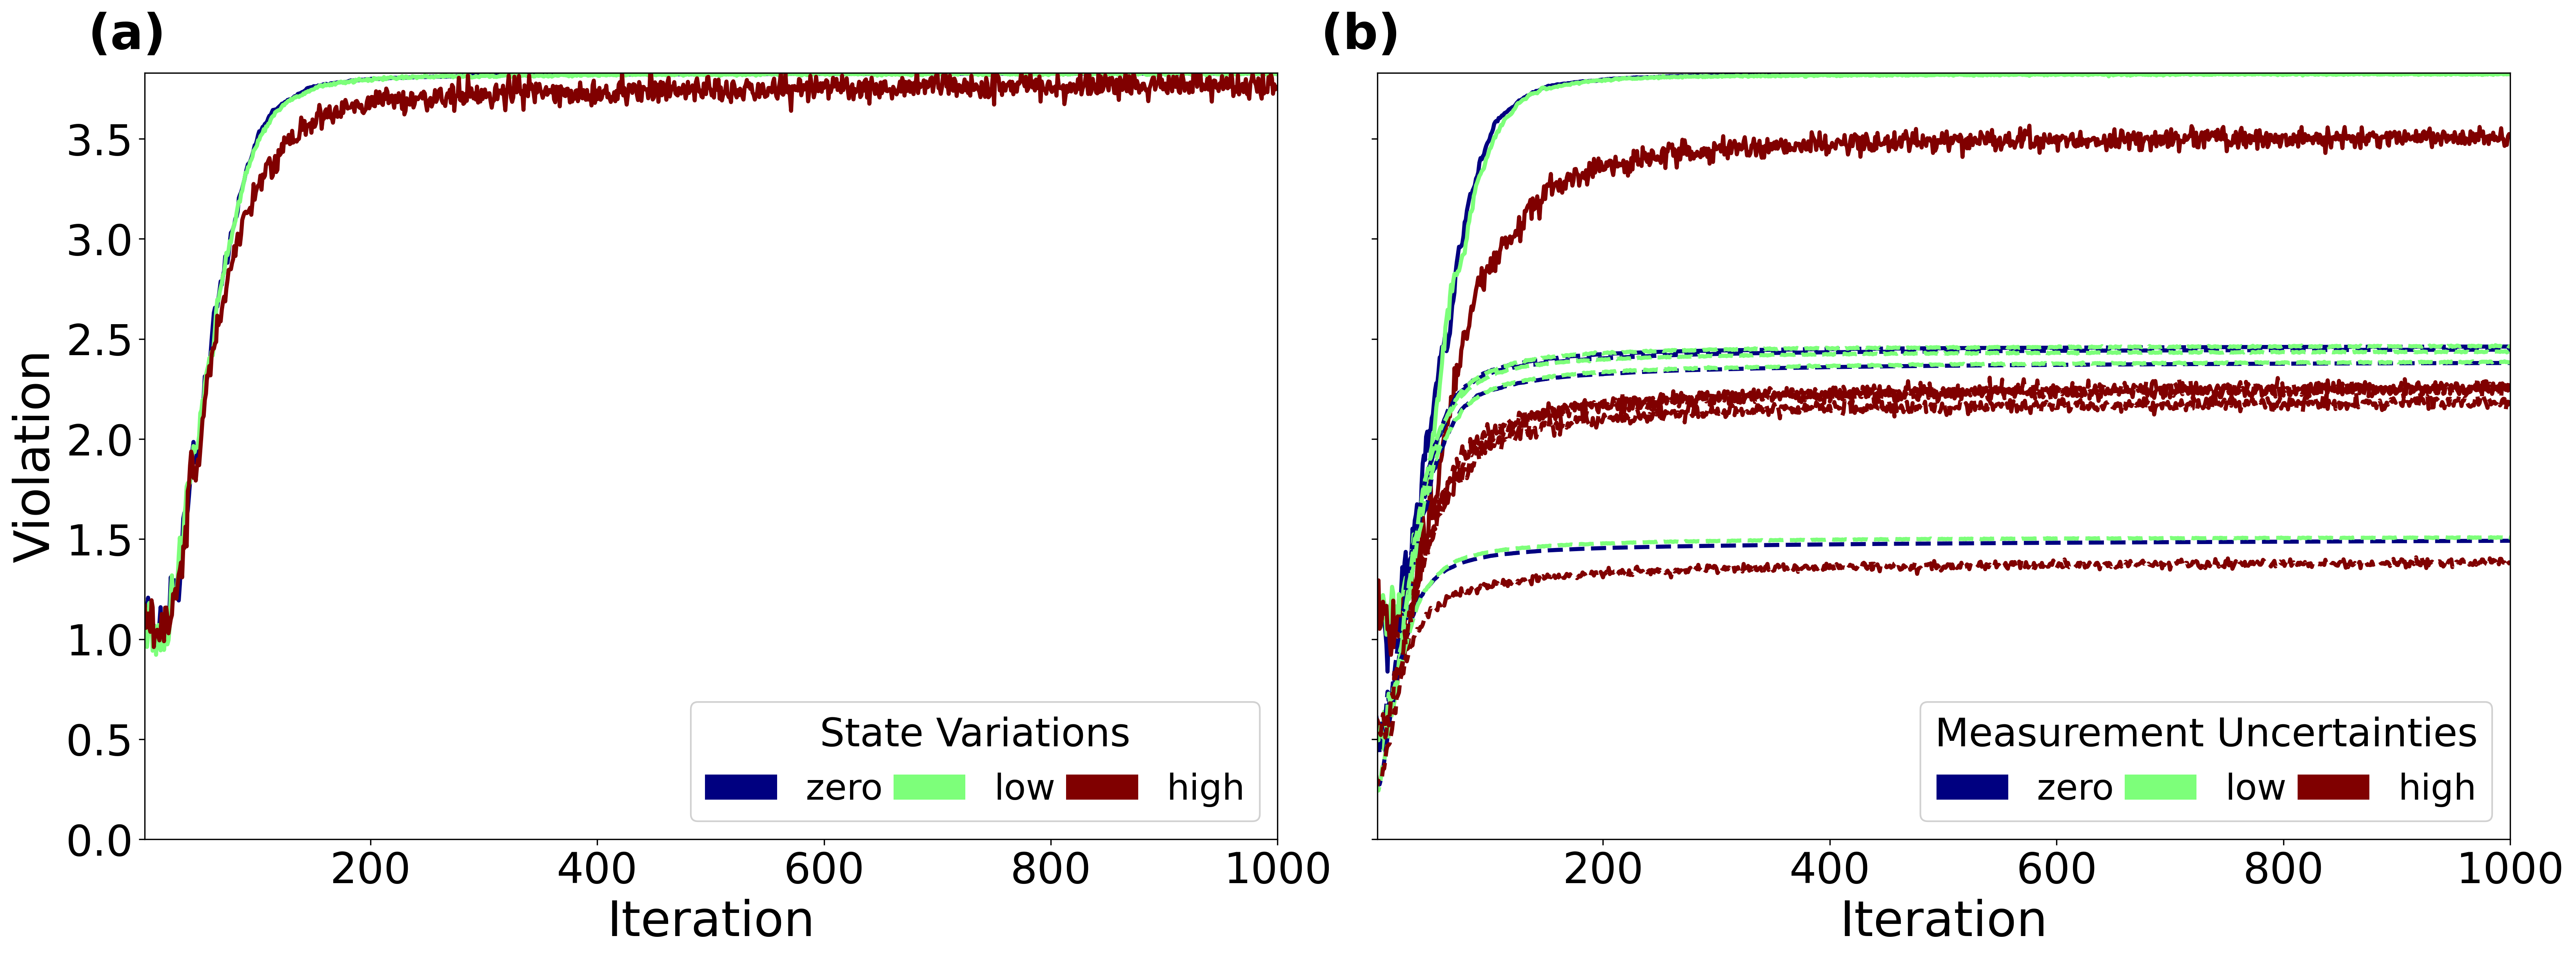

In [24]:
    # =============================================================================
# --- 6. 绘图 (Plotting Figure 2) ---
# =============================================================================
print("Generating Figure 2...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9), sharey=True, dpi=300)
plt.style.use('default') # 保持您满意的风格

# --- 图(a): 效率对比 ---
colors_1a = plt.cm.jet(np.linspace(0, 1, len(STATES_VARIATIONS_1a)))
variation_colors = {name: colors_1a[i] for i, name in enumerate(STATES_VARIATIONS_1a.keys())}
states_lines1 = {"MES": '-'}

for r in results_1a:
       ax1.plot(r['mean_history'],
             color=variation_colors[r['state_variation_name']],
             linestyle=states_lines1[r['state_name']],
             linewidth=2.5)

ax1.text(-0.05, 1.08, '(a)', transform=ax1.transAxes, fontsize=30, fontweight='bold', va='top')

# 图例 (a)
leg_variations = [Patch(facecolor=variation_colors[name], label=name) for name in STATES_VARIATIONS_1a.keys()]
leg_states = [Line2D([0], [0], color='black', lw=2.5, linestyle=ls, label=name) for name, ls in states_lines1.items()]
legend1 = ax1.legend(handles=leg_variations, loc='lower right', title='State Variations', ncol=3, columnspacing=0.3, fontsize=22, title_fontsize=24)
ax1.add_artist(legend1)
# --- 新增代码: 设置a图的x轴范围 ---
ax1.set_xlim(1, 1000)

# --- 图(b):  ---
colors_1b = plt.cm.jet(np.linspace(0, 1, len(MEASUREMENT_UNCERTAINTY_1b)))
uncertainty_colors = {name: colors_1b[i] for i, name in enumerate(MEASUREMENT_UNCERTAINTY_1b.keys())}
states_lines2 = {"MES": '-', "RMS 1": '--', 'RMS 2': '--', 'RMS 3': '--', 'RMS 4': '--'}
for r in results_1b:
   ax2.plot(r['mean_history'],
             color=uncertainty_colors[r['uncertainty_name']],
             linestyle=states_lines2[r['state_name']],
             linewidth=2.5)

ax2.text(-0.05, 1.08, '(b)', transform=ax2.transAxes, fontsize=30, fontweight='bold', va='top')

# 图例 (b)
leg_uncertainty = [Patch(facecolor=uncertainty_colors[name], label=name) for name in MEASUREMENT_UNCERTAINTY_1b.keys()]
legend2 = ax2.legend(handles=leg_uncertainty, loc='lower right', ncol=5 , columnspacing=0.3 ,title='Measurement Uncertainties', fontsize=22, title_fontsize=24)
leg_states2 = [Line2D([0], [0], color='black', lw=2.5, linestyle=ls, label=name) for name, ls in states_lines2.items()]
ax2.add_artist(legend2)
# --- 新增代码: 设置a图的x轴范围 ---
ax2.set_xlim(1, 1000)
# --- 全局设置 ---
for ax in [ax1, ax2]:
   ax.set_xlabel("Iteration", fontsize=30)
   ax.grid(False)
   ax.set_ylim(bottom=0)
   ax.tick_params(axis='both', which='major', labelsize=26)

# --- Control the overall shared y-axis range ---
# Setting the y-limit on one shared axis applies to all.
# Set the desired maximum y-value for the Violation axis.
# Adjust this value (e.g., 3.0) higher or lower as needed.
overall_max_violation = 1+2*np.sqrt(2) # <--- Set your desired max Y value here
ax1.set_ylim(top=overall_max_violation) # Apply the top limit to ax1 (which shares with ax2)
ax1.set_ylim(bottom=0) # Apply the top limit to ax1 (which shares with ax2)

ax1.set_ylabel("Violation", fontsize=30)
fig.tight_layout(rect=[0, 0.03, 1, 0.95], w_pad=0.01)  # New: Adjust w_pad parameter

plt.savefig("figure4_variation_uncertainty.pdf", format='pdf', bbox_inches='tight')
plt.show()

